In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.stats.api as sms
import re

from src.utils import pmf_utils

### Load Config

In [2]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

mds_updrs_conf = main_config.MDS_UPDRS


NameError: name 'Path' is not defined

### Import Data

In [ ]:
data_data = pd.read_csv(Path(processed_dir, "processed_data_accu_60_filtered.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_accu_60.csv"), index_col=None)

### Preliminary

In [ ]:
all_subjects = processed_metadata['subject_id'].unique()
stanford_subjects = processed_metadata[processed_metadata['experiment_site'] == 'Stanford']['subject_id'].unique()
ucla_subjects = processed_metadata[processed_metadata['experiment_site'] == 'UCLA']['subject_id'].unique()
case_western_subjects = processed_metadata[processed_metadata['experiment_site'] == 'Case_Western']['subject_id'].unique()

In [ ]:
# Getting indices of on and off treatment from same subject in processed metadata
treatment_idx_all = pd.DataFrame(columns=['subject', 'off', 'on'])

for idx, sub in enumerate(processed_metadata['subject_id'].unique()):
    sub_df = processed_metadata.loc[processed_metadata['subject_id'] == sub]

    # put off treatment first column and on treatment second column one row at a time
    treatment_idx_all.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

all_subjects = treatment_idx_all['subject'].unique()

print(f"All subjects (n={len(all_subjects)}): {all_subjects}")


All subjects (n=35): ['P1' 'P3' 'P4' 'P6' 'P7' 'P9' 'P11' 'P12' 'P13' 'P17' 'P18' 'P19' 'P20'
 'P22' 'P23' 'P24' 'CG' 'COH' 'MBY' 'DP' 'FUR' 'LBR' 'MAR' 'SMI' 'PAM'
 'RW' 'BBK' 'BER' 'DCAM' 'ALE' 'DMO' 'RBA' 'RDE' 'SGA' 'LHO']


In [ ]:
new_trem_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'tremor_dominant']['subject_id'].unique()
new_brady_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'bradykinesia_dominant']['subject_id'].unique()
new_intermediate_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'intermediate']['subject_id'].unique()
print(f"New tremor_subjects: {len(new_trem_subjects)} \t {new_trem_subjects}")
print(f"New brady_subjects: {len(new_brady_subjects)} \t{new_brady_subjects}")
print(f"New intermediate_subjects: {len(new_intermediate_subjects)} \t{new_intermediate_subjects}")

New tremor_subjects: 7 	 ['P6' 'P7' 'P11' 'P12' 'P17' 'P18' 'P19']
New brady_subjects: 7 	['P1' 'P4' 'P9' 'P13' 'P20' 'P22' 'P23']
New intermediate_subjects: 1 	['P24']


### Difference Matrix

In [ ]:
difference_metadata = pd.DataFrame()

for idx, sub in enumerate(all_subjects):
    off_idx, on_idx = treatment_idx_all.loc[treatment_idx_all['subject']==sub, ['off', 'on']].values[0]
    difference_metadata.loc[idx, 'subject'] = sub
    # dependent variables
    difference_metadata.loc[idx, 'off_updrs_score'] = processed_metadata.loc[off_idx, 'UPDRS']
    difference_metadata.loc[idx, 'off_tremor_score'] = processed_metadata.loc[off_idx, 'tremor_score']
    difference_metadata.loc[idx, 'off_bradykinesia_score'] = processed_metadata.loc[off_idx, 'bradykinesia_score']
    difference_metadata.loc[idx, 'on_updrs_score'] = processed_metadata.loc[on_idx, 'UPDRS']
    difference_metadata.loc[idx, 'on_tremor_score'] = processed_metadata.loc[on_idx, 'tremor_score']
    difference_metadata.loc[idx, 'on_bradykinesia_score'] = processed_metadata.loc[on_idx, 'bradykinesia_score']
    # independent variables - difference in separation
    updrs_change = processed_metadata.loc[on_idx, 'UPDRS'] - processed_metadata.loc[off_idx, 'UPDRS']
    difference_metadata.loc[idx, 'updrs_change'] = updrs_change
    tremor_score_change = processed_metadata.loc[on_idx, 'tremor_score'] - processed_metadata.loc[off_idx, 'tremor_score']
    difference_metadata.loc[idx, 'tremor_score_change'] = tremor_score_change
    bradykinesia_score_change = processed_metadata.loc[on_idx, 'bradykinesia_score'] - processed_metadata.loc[off_idx, 'bradykinesia_score']
    difference_metadata.loc[idx, 'bradykinesia_score_change'] = bradykinesia_score_change
    off_med_bias_separation = processed_metadata.loc[off_idx, 'positive_bias'] - processed_metadata.loc[off_idx, 'equal_bias']
    difference_metadata.loc[idx, 'off_med_bias_separation'] = off_med_bias_separation
    on_med_bias_separation = processed_metadata.loc[on_idx, 'positive_bias'] - processed_metadata.loc[on_idx, 'equal_bias']
    difference_metadata.loc[idx, 'on_med_bias_separation'] = on_med_bias_separation


temp_metadata = difference_metadata.copy()
# Convert to numeric, forcing errors to NaN
temp_metadata = temp_metadata.apply(pd.to_numeric, errors='coerce')

In [ ]:
positive_col = 'blue'
equal_col = 'red'

------------------------------------------------------
Model for Off Medication Bias Difference: UPDRS 
------------------------------------------------------
                 Coefficient   P-value
const              -0.054639  0.501602
off_updrs_score     0.003815  0.317686
------------------------------------------------------
Model for On Medication Bias Difference: UPDRS 
------------------------------------------------------
                Coefficient   P-value
const             -0.037407  0.520996
on_updrs_score     0.006785  0.073245


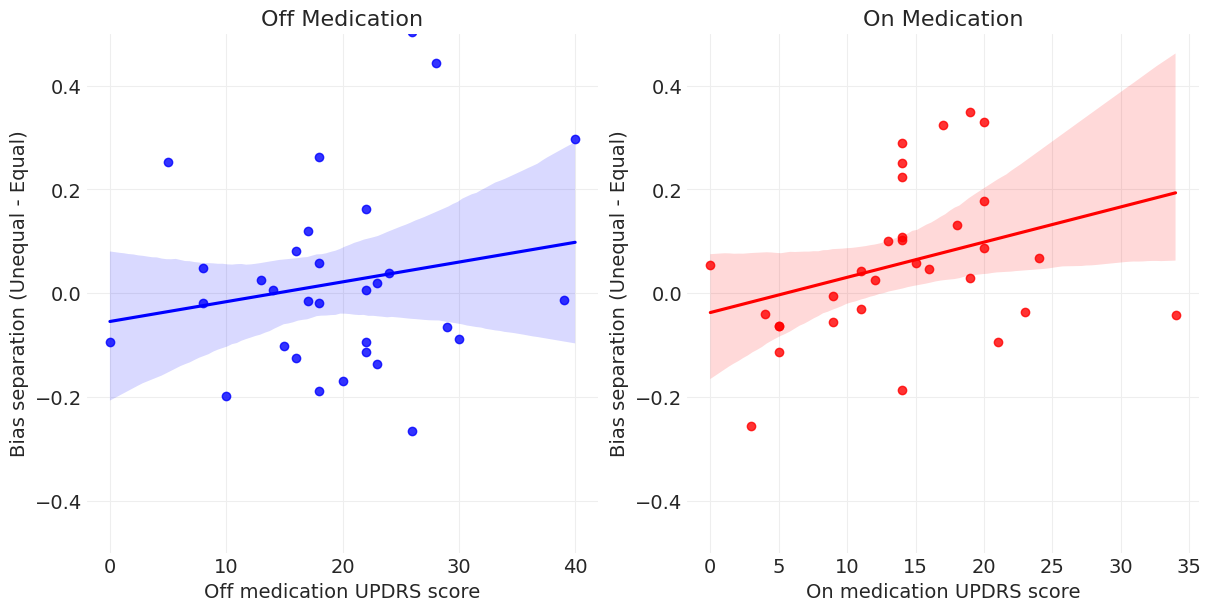

In [ ]:
print("------------------------------------------------------")
print(f"Model for Off Medication Bias Difference: UPDRS ")
print("------------------------------------------------------")
X = temp_metadata[['off_updrs_score']]  # Ensure X is a DataFrame
X = sm.add_constant(X)  # Add intercept term
y = temp_metadata['off_med_bias_separation']
model = sm.OLS(y, X, missing='drop').fit()  # Ignore NaNs automatically
results = pd.DataFrame({'Coefficient': model.params, 'P-value': model.pvalues})
print(results)
print("------------------------------------------------------")
print(f"Model for On Medication Bias Difference: UPDRS ")
print("------------------------------------------------------")
X = temp_metadata[['on_updrs_score']]  # Ensure X is a DataFrame
X = sm.add_constant(X)  # Add intercept term
y = temp_metadata['on_med_bias_separation']
model = sm.OLS(y, X, missing='drop').fit()  # Ignore NaNs automatically
results = pd.DataFrame({'Coefficient': model.params, 'P-value': model.pvalues})
print(results)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(x='off_updrs_score', y='off_med_bias_separation', data=temp_metadata, ax=axs[0], color=positive_col, label='Off Medication')
axs[0].set_xlabel('Off medication UPDRS score');
axs[0].set_ylabel('Bias separation (Unequal - Equal)');
axs[0].set_title('Off Medication')
axs[0].set_ylim(-0.5, 0.5)
sns.regplot(x='on_updrs_score', y='on_med_bias_separation', data=temp_metadata, ax=axs[1], color=equal_col, label='On Medication')
axs[1].set_xlabel('On medication UPDRS score');
axs[1].set_ylabel('Bias separation (Unequal - Equal)');
axs[1].set_title('On Medication')
axs[1].set_ylim(-0.5, 0.5)
plt.tight_layout()
plt.show()



------------------------------------------------------
Model for Off Medication Bias Difference: Tremor Score 
------------------------------------------------------
                  Coefficient   P-value
const                0.199348  0.106725
off_tremor_score    -0.233457  0.192692
------------------------------------------------------
Model for On Medication Bias Difference: Tremor Score 
------------------------------------------------------
                 Coefficient   P-value
const               0.064703  0.295754
on_tremor_score    -0.002595  0.985442


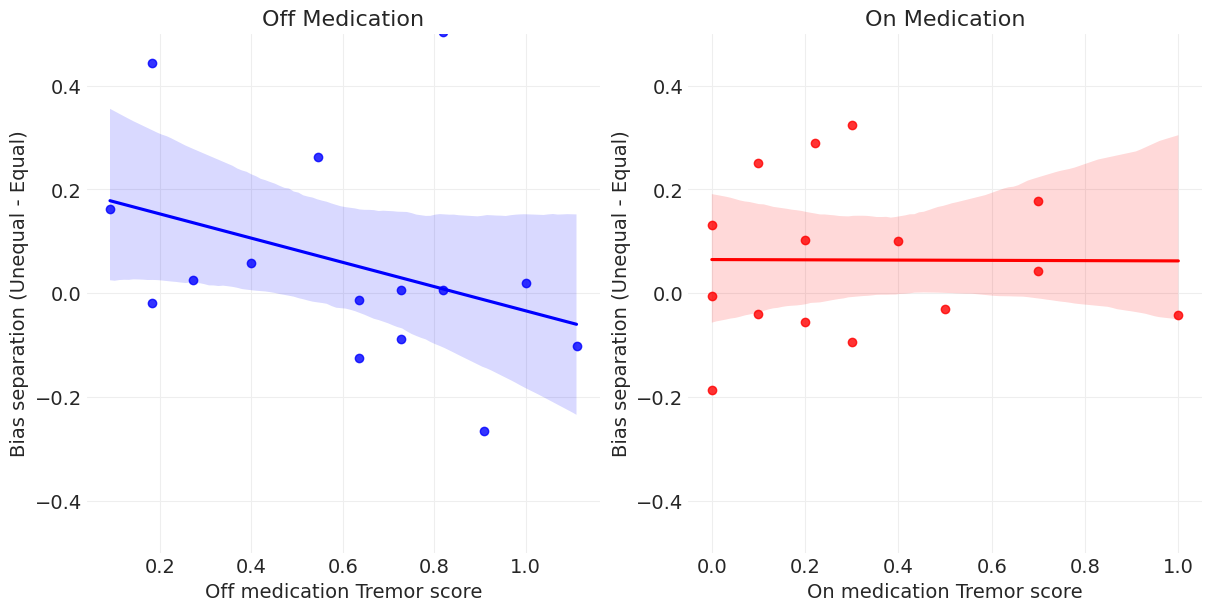

In [ ]:
print("------------------------------------------------------")
print(f"Model for Off Medication Bias Difference: Tremor Score ")
print("------------------------------------------------------")
X = temp_metadata[['off_tremor_score']]  # Ensure X is a DataFrame
X = sm.add_constant(X)  # Add intercept term
y = temp_metadata['off_med_bias_separation']
model = sm.OLS(y, X, missing='drop').fit()  # Ignore NaNs automatically
results = pd.DataFrame({'Coefficient': model.params, 'P-value': model.pvalues})
print(results)
print("------------------------------------------------------")
print(f"Model for On Medication Bias Difference: Tremor Score ")
print("------------------------------------------------------")
X = temp_metadata[['on_tremor_score']]  # Ensure X is a DataFrame
X = sm.add_constant(X)  # Add intercept term
y = temp_metadata['on_med_bias_separation']
model = sm.OLS(y, X, missing='drop').fit()  # Ignore NaNs automatically
results = pd.DataFrame({'Coefficient': model.params, 'P-value': model.pvalues})
print(results)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(x='off_tremor_score', y='off_med_bias_separation', data=temp_metadata, ax=axs[0], color=positive_col, label='Off Medication')
axs[0].set_xlabel('Off medication Tremor score');
axs[0].set_ylabel('Bias separation (Unequal - Equal)');
axs[0].set_title('Off Medication')
axs[0].set_ylim(-0.5, 0.5)
sns.regplot(x='on_tremor_score', y='on_med_bias_separation', data=temp_metadata, ax=axs[1], color=equal_col, label='On Medication')
axs[1].set_xlabel('On medication Tremor score');
axs[1].set_ylabel('Bias separation (Unequal - Equal)');
axs[1].set_title('On Medication')
axs[1].set_ylim(-0.5, 0.5)
plt.tight_layout()
plt.show()

------------------------------------------------------
Model for Off Medication Bias Difference: Bradykinesia Score 
------------------------------------------------------
                        Coefficient   P-value
const                      0.014064  0.917699
off_bradykinesia_score     0.054005  0.720977
------------------------------------------------------
Model for On Medication Bias Difference: Bradykinesia Score 
------------------------------------------------------
                       Coefficient   P-value
const                     0.010968  0.896649
on_bradykinesia_score     0.095390  0.480954


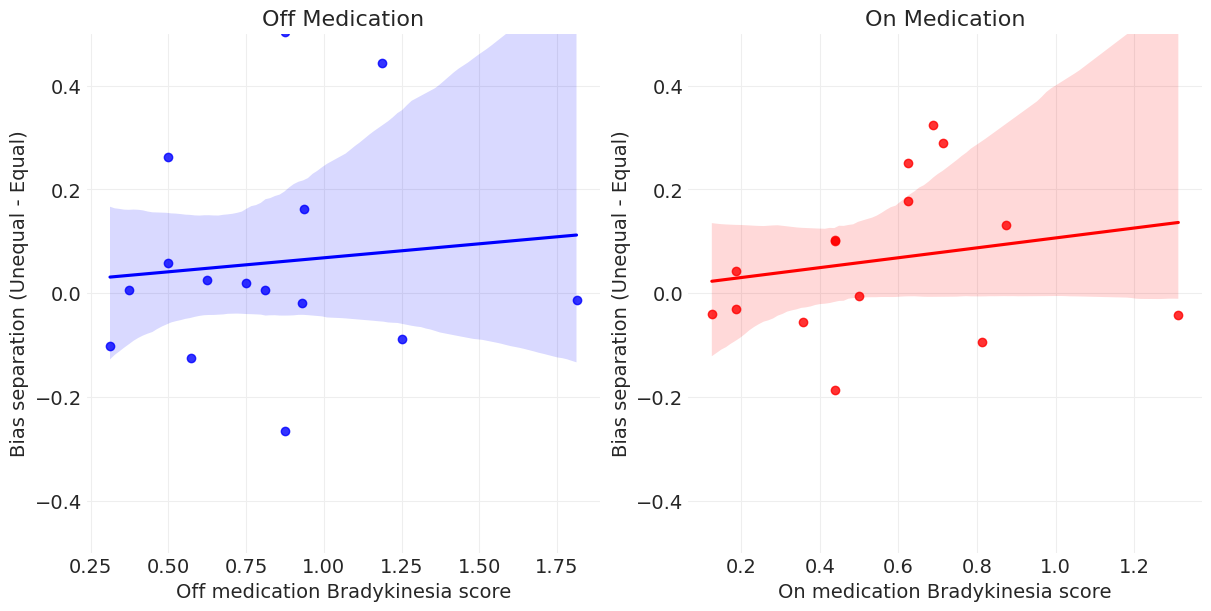

In [ ]:
print("------------------------------------------------------")
print(f"Model for Off Medication Bias Difference: Bradykinesia Score ")
print("------------------------------------------------------")
X = temp_metadata[['off_bradykinesia_score']]  # Ensure X is a DataFrame
X = sm.add_constant(X)  # Add intercept term
y = temp_metadata['off_med_bias_separation']
model = sm.OLS(y, X, missing='drop').fit()  # Ignore NaNs automatically
results = pd.DataFrame({'Coefficient': model.params, 'P-value': model.pvalues})
print(results)
print("------------------------------------------------------")
print(f"Model for On Medication Bias Difference: Bradykinesia Score ")
print("------------------------------------------------------")
X = temp_metadata[['on_bradykinesia_score']]  # Ensure X is a DataFrame
X = sm.add_constant(X)  # Add intercept term
y = temp_metadata['on_med_bias_separation']
model = sm.OLS(y, X, missing='drop').fit()  # Ignore NaNs automatically
results = pd.DataFrame({'Coefficient': model.params, 'P-value': model.pvalues})
print(results)



fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(x='off_bradykinesia_score', y='off_med_bias_separation', data=temp_metadata, ax=axs[0], color=positive_col, label='Off Medication')
axs[0].set_xlabel('Off medication Bradykinesia score');
axs[0].set_ylabel('Bias separation (Unequal - Equal)');
axs[0].set_title('Off Medication')
axs[0].set_ylim(-0.5, 0.5)
sns.regplot(x='on_bradykinesia_score', y='on_med_bias_separation', data=temp_metadata, ax=axs[1], color=equal_col, label='On Medication')
axs[1].set_xlabel('On medication Bradykinesia score');
axs[1].set_ylabel('Bias separation (Unequal - Equal)');
axs[1].set_title('On Medication')
axs[1].set_ylim(-0.5, 0.5)
plt.tight_layout()
plt.show()

In [ ]:
print("------------------------------------------------------")
print(f"Model for Off Medication Bias Difference ")
print("------------------------------------------------------")
X = temp_metadata[['off_updrs_score', 'off_tremor_score', 'off_bradykinesia_score']]
X = sm.add_constant(X)
y = temp_metadata['off_med_bias_separation']
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


print("------------------------------------------------------")
print(f"Model for On Medication Bias Difference ")
print("------------------------------------------------------")
X = temp_metadata[['on_updrs_score', 'on_tremor_score', 'on_bradykinesia_score']]
X = sm.add_constant(X)
y = temp_metadata['on_med_bias_separation']
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

------------------------------------------------------
Model for Off Medication Bias Difference 
------------------------------------------------------
                               OLS Regression Results                              
Dep. Variable:     off_med_bias_separation   R-squared:                       0.377
Model:                                 OLS   Adj. R-squared:                  0.207
Method:                      Least Squares   F-statistic:                     2.216
Date:                     Wed, 19 Feb 2025   Prob (F-statistic):              0.144
Time:                             05:37:28   Log-Likelihood:                 6.3496
No. Observations:                       15   AIC:                            -4.699
Df Residuals:                           11   BIC:                            -1.867
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
        

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [ ]:
independend_variable = ['positive_bias', 'positive_psych_bias', 'positive_psych_alpha', 'positive_psych_beta', 'positive_psych_lapse', 'positive_psych_guess',
                        'equal_bias', 'equal_psych_bias', 'equal_psych_alpha', 'equal_psych_beta', 'equal_psych_lapse','equal_psych_guess']

# dependend_variable = ['210_Tremor', '301_Speech', '302_Facial_Expression', '303a_Rigidity_Neck', '303b_Rigidity_RUE', '303c_Rigidity_LUE', '303d_Rigidity_RLE',
#                         '303e_Rigidity_LLE', '304a_Finger_Tapping_RUE', '304b_Finger_Tapping_LUE', '305a_Hand_Movements_RUE', '305b_Hand_Movements_LUE',
#                         '306a_Pronation_Supination_Movements_RUE', '306b_Pronation_Supination_Movements_LUE', '307a_Toe_Tapping_RLE', '307b_Toe_Tapping_LLE',
#                         '308a_Leg_Agility_RLE', '308b_Leg_Agility_LLE', '309_Arising_from_Chair', '310_Gait', '311_Freezing_of_Gait', '312_Postural_Stability',
#                         '313_Posture', '314_Global_Spontaneity_of_Movement', '315a_Postural_Tremor_RUE', '315b_Postural_Tremor_LUE', '316a_Kinetic_Tremor_RUE',
#                         '316b_Kinetic_Tremor_LUE', '317a_Rest_Tremor_Amplitude_RUE', '317b_Rest_Tremor_Amplitude_LUE', '317c_Rest_Tremor_Amplitude_RLE',
#                         '317d_Rest_Tremor_Amplitude_LLE', '317e_Rest_Tremor_Amplitude_Lip_Jaw', '318_Constancy_of_Rest_Tremor',
dependend_variable = ['UPDRS', 'tremor_score', 'bradykinesia_score']

In [ ]:
positive_col = 'blue'
equal_col = 'red'

1. All subjects UPDRS correlation

In [ ]:
difference_metadata = pd.DataFrame(columns=['subject', 'UPDRS', 'tremor_score', 'bradykinesia_score', 'bias_separation_change', 'bias_separation_prct_change'])

for idx, sub in enumerate(stanford_subjects):
    off_idx, on_idx = treatment_idx_all.loc[treatment_idx_all['subject']==sub, ['off', 'on']].values[0]
    difference_metadata.loc[idx, 'subject'] = sub
    # dependent variables
    difference_metadata.loc[idx, 'UPDRS'] = processed_metadata.loc[off_idx, 'UPDRS']
    difference_metadata.loc[idx, 'tremor_score'] = processed_metadata.loc[off_idx, 'tremor_score']
    difference_metadata.loc[idx, 'bradykinesia_score'] = processed_metadata.loc[off_idx, 'bradykinesia_score']

    # # independent variables - individual change
    # off_med_positive_bias = processed_metadata.loc[off_idx, 'positive_bias']
    # on_med_positive_bias = processed_metadata.loc[on_idx, 'positive_bias']
    # difference_metadata.loc[idx, 'positive_bias_change'] = on_med_positive_bias - off_med_positive_bias
    # difference_metadata.loc[idx, 'positive_bias_prct_change'] = (on_med_positive_bias - off_med_positive_bias) / off_med_positive_bias
    # off_med_equal_bias = processed_metadata.loc[off_idx, 'equal_bias']
    # on_med_equal_bias = processed_metadata.loc[on_idx, 'equal_bias']
    # difference_metadata.loc[idx, 'equal_bias_change'] = on_med_equal_bias - off_med_equal_bias
    # difference_metadata.loc[idx, 'equal_bias_prct_change'] = (on_med_equal_bias - off_med_equal_bias) / off_med_equal_bias

    # # independent variables - difference in separation
    # off_med_bias_separation = processed_metadata.loc[off_idx, 'positive_bias'] - processed_metadata.loc[off_idx, 'equal_bias']
    # on_med_bias_separation = processed_metadata.loc[on_idx, 'positive_bias'] - processed_metadata.loc[on_idx, 'equal_bias']
    # difference_metadata.loc[idx, 'bias_separation_change'] = on_med_bias_separation - off_med_bias_separation
    # difference_metadata.loc[idx, 'bias_separation_prct_change'] = (on_med_bias_separation - off_med_bias_separation) / off_med_bias_separation



    # independent variables - difference in separation
    off_med_bias_separation = processed_metadata.loc[off_idx, 'positive_bias'] - processed_metadata.loc[off_idx, 'equal_bias']
    on_med_bias_separation = processed_metadata.loc[on_idx, 'positive_bias'] - processed_metadata.loc[on_idx, 'equal_bias']
    difference_metadata.loc[idx, 'off_med_bias_separation'] = off_med_bias_separation
    difference_metadata.loc[idx, 'on_med_bias_separation'] = on_med_bias_separation


temp_metadata = difference_metadata.copy()
# # remove outliers
# temp_metadata = temp_metadata[temp_metadata['bias_separation_prct_change'] < 30]

# Convert to numeric, forcing errors to NaN
temp_metadata = temp_metadata.apply(pd.to_numeric, errors='coerce')

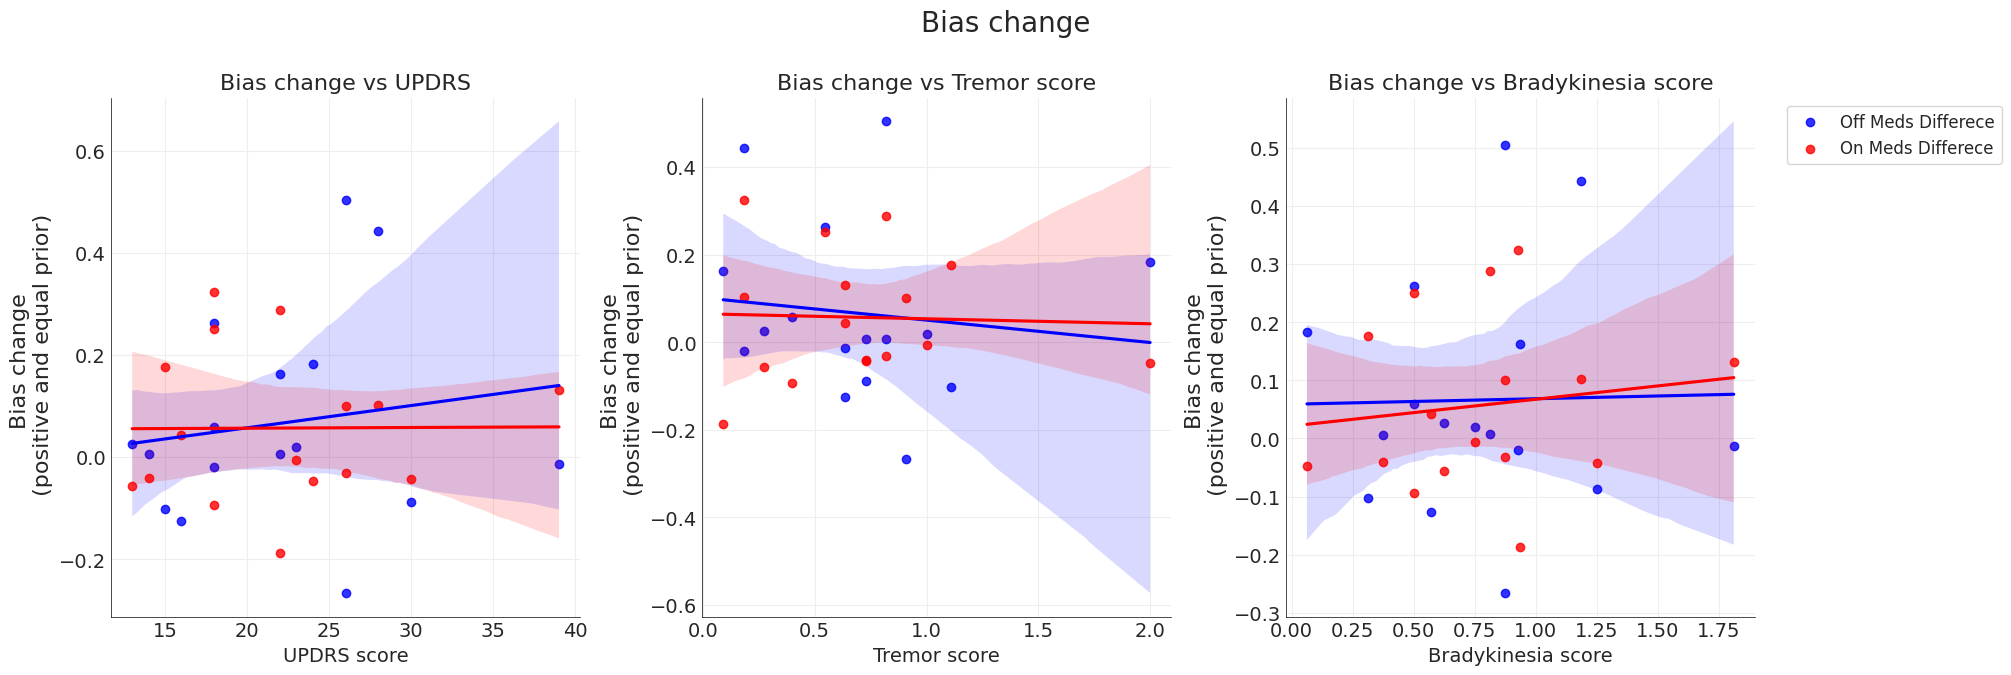

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.regplot(x='UPDRS', y='off_med_bias_separation', data=temp_metadata, ax=axs[0], color=positive_col)
sns.regplot(x='UPDRS', y='on_med_bias_separation', data=temp_metadata, ax=axs[0], color=equal_col)
axs[0].set_title('Bias change vs UPDRS')
axs[0].set_xlabel('UPDRS score')

sns.regplot(x='tremor_score', y='off_med_bias_separation', data=temp_metadata, ax=axs[1], color=positive_col)
sns.regplot(x='tremor_score', y='on_med_bias_separation', data=temp_metadata, ax=axs[1], color=equal_col)
axs[1].set_title('Bias change vs Tremor score')
axs[1].set_xlabel('Tremor score')

sns.regplot(x='bradykinesia_score', y='off_med_bias_separation', data=temp_metadata, ax=axs[2], color=positive_col, label='Off Meds Differece')
sns.regplot(x='bradykinesia_score', y='on_med_bias_separation', data=temp_metadata, ax=axs[2], color=equal_col, label='On Meds Differece')
axs[2].set_title('Bias change vs Bradykinesia score')
axs[2].set_xlabel('Bradykinesia score')

for ax in axs:
    ax.set_ylabel('Bias change \n (positive and equal prior)', fontsize=16)
    # add bottom and left box line
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Bias change', fontsize=20, y=1.10)
plt.tight_layout()
plt.show()



In [ ]:
print("------------------------------------------------------")
print(f"Model for Off meds bias difference ")
print("------------------------------------------------------")

y = temp_metadata['off_med_bias_separation']
# Fit the model
model = sm.OLS(y, X).fit()
# Print the summary
print(model.summary())

print("------------------------------------------------------")
print(f"Model for On meds bias difference ")
print("------------------------------------------------------")

y = temp_metadata['on_med_bias_separation']
# Fit the model
model = sm.OLS(y, X).fit()
# Print the summary
print(model.summary())

------------------------------------------------------
Model for Off meds bias difference 
------------------------------------------------------
                               OLS Regression Results                              
Dep. Variable:     off_med_bias_separation   R-squared:                       0.388
Model:                                 OLS   Adj. R-squared:                  0.235
Method:                      Least Squares   F-statistic:                     2.539
Date:                     Tue, 18 Feb 2025   Prob (F-statistic):              0.106
Time:                             22:09:22   Log-Likelihood:                 7.2489
No. Observations:                       16   AIC:                            -6.498
Df Residuals:                           12   BIC:                            -3.407
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
              

In [ ]:
difference_metadata = pd.DataFrame(columns=['subject', 'UPDRS', 'tremor_score', 'bradykinesia_score', 'bias_separation_change', 'bias_separation_prct_change'])

for idx, sub in enumerate(new_subjects):
    off_idx, on_idx = treatment_idx_all.loc[treatment_idx_all['subject']==sub, ['off', 'on']].values[0]
    difference_metadata.loc[idx, 'subject'] = sub
    # dependent variables
    difference_metadata.loc[idx, 'UPDRS'] = processed_metadata.loc[off_idx, 'UPDRS']
    difference_metadata.loc[idx, 'tremor_score'] = processed_metadata.loc[off_idx, 'tremor_score']
    difference_metadata.loc[idx, 'bradykinesia_score'] = processed_metadata.loc[off_idx, 'bradykinesia_score']

    # independent variables - individual change
    off_med_positive_bias = processed_metadata.loc[off_idx, 'positive_bias']
    on_med_positive_bias = processed_metadata.loc[on_idx, 'positive_bias']
    difference_metadata.loc[idx, 'positive_bias_change'] = on_med_positive_bias - off_med_positive_bias
    difference_metadata.loc[idx, 'positive_bias_prct_change'] = (on_med_positive_bias - off_med_positive_bias) / off_med_positive_bias
    off_med_equal_bias = processed_metadata.loc[off_idx, 'equal_bias']
    on_med_equal_bias = processed_metadata.loc[on_idx, 'equal_bias']
    difference_metadata.loc[idx, 'equal_bias_change'] = on_med_equal_bias - off_med_equal_bias
    difference_metadata.loc[idx, 'equal_bias_prct_change'] = (on_med_equal_bias - off_med_equal_bias) / off_med_equal_bias

    # independent variables - difference in separation
    off_med_bias_separation = processed_metadata.loc[off_idx, 'positive_bias'] - processed_metadata.loc[off_idx, 'equal_bias']
    on_med_bias_separation = processed_metadata.loc[on_idx, 'positive_bias'] - processed_metadata.loc[on_idx, 'equal_bias']
    difference_metadata.loc[idx, 'bias_separation_change'] = on_med_bias_separation - off_med_bias_separation
    difference_metadata.loc[idx, 'bias_separation_prct_change'] = (on_med_bias_separation - off_med_bias_separation) / off_med_bias_separation

temp_metadata = difference_metadata.copy()
# # remove outliers
# temp_metadata = temp_metadata[temp_metadata['bias_separation_prct_change'] < 30]

# Convert to numeric, forcing errors to NaN
temp_metadata = temp_metadata.apply(pd.to_numeric, errors='coerce')

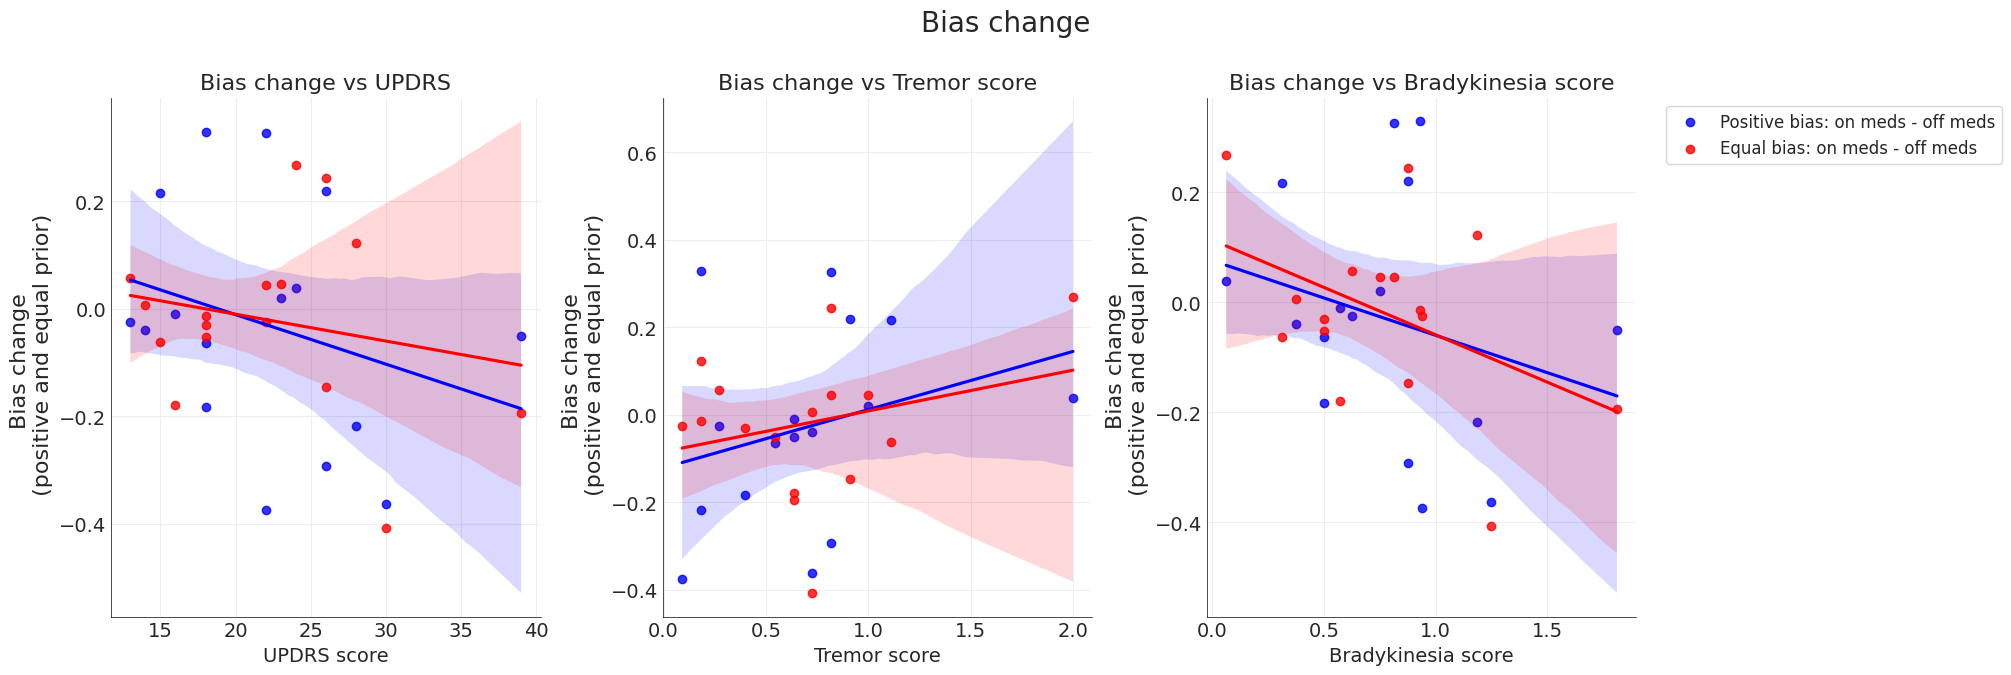

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.regplot(x='UPDRS', y='positive_bias_change', data=temp_metadata, ax=axs[0], color=positive_col)
sns.regplot(x='UPDRS', y='equal_bias_change', data=temp_metadata, ax=axs[0], color=equal_col)
axs[0].set_title('Bias change vs UPDRS')
axs[0].set_xlabel('UPDRS score')

sns.regplot(x='tremor_score', y='positive_bias_change', data=temp_metadata, ax=axs[1], color=positive_col)
sns.regplot(x='tremor_score', y='equal_bias_change', data=temp_metadata, ax=axs[1], color=equal_col)
axs[1].set_title('Bias change vs Tremor score')
axs[1].set_xlabel('Tremor score')

sns.regplot(x='bradykinesia_score', y='positive_bias_change', data=temp_metadata, ax=axs[2], color=positive_col, label='Positive bias: on meds - off meds')
sns.regplot(x='bradykinesia_score', y='equal_bias_change', data=temp_metadata, ax=axs[2], color=equal_col, label='Equal bias: on meds - off meds')
axs[2].set_title('Bias change vs Bradykinesia score')
axs[2].set_xlabel('Bradykinesia score')

for ax in axs:
    ax.set_ylabel('Bias change \n (positive and equal prior)', fontsize=16)
    # add bottom and left box line
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Bias change', fontsize=20, y=1.10)
plt.tight_layout()
plt.show()



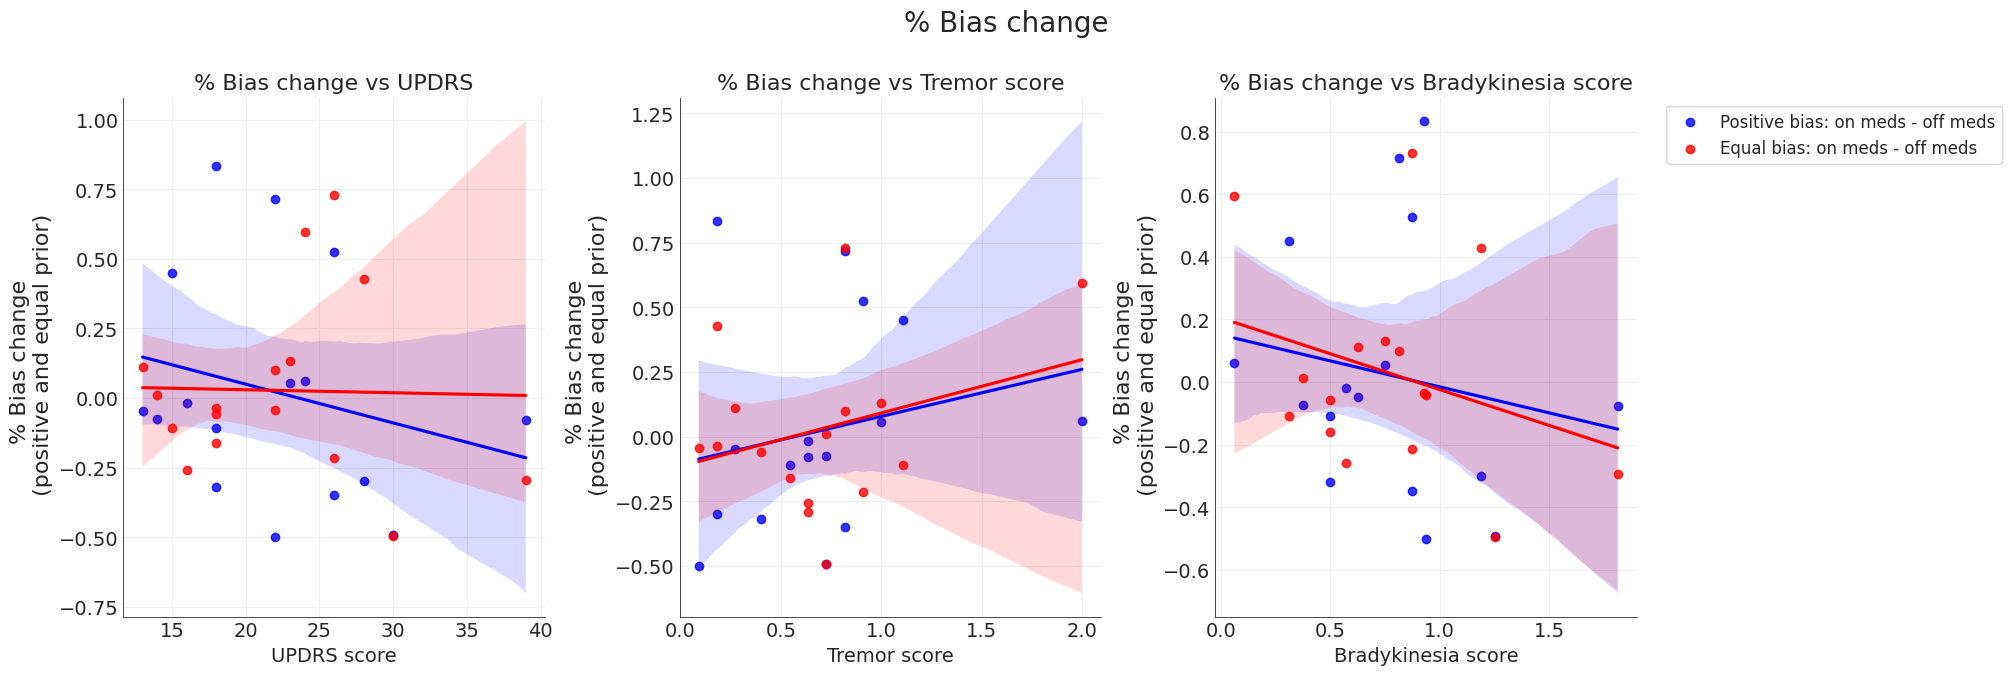

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.regplot(x='UPDRS', y='positive_bias_prct_change', data=temp_metadata, ax=axs[0], color=positive_col)
sns.regplot(x='UPDRS', y='equal_bias_prct_change', data=temp_metadata, ax=axs[0], color=equal_col)
axs[0].set_title('% Bias change vs UPDRS')
axs[0].set_xlabel('UPDRS score')

sns.regplot(x='tremor_score', y='positive_bias_prct_change', data=temp_metadata, ax=axs[1], color=positive_col)
sns.regplot(x='tremor_score', y='equal_bias_prct_change', data=temp_metadata, ax=axs[1], color=equal_col)
axs[1].set_title('% Bias change vs Tremor score')
axs[1].set_xlabel('Tremor score')

sns.regplot(x='bradykinesia_score', y='positive_bias_prct_change', data=temp_metadata, ax=axs[2], color=positive_col, label='Positive bias: on meds - off meds')
sns.regplot(x='bradykinesia_score', y='equal_bias_prct_change', data=temp_metadata, ax=axs[2], color=equal_col, label='Equal bias: on meds - off meds')
axs[2].set_title('% Bias change vs Bradykinesia score')
axs[2].set_xlabel('Bradykinesia score')

for ax in axs:
    ax.set_ylabel('% Bias change \n (positive and equal prior)', fontsize=16)
    # add bottom and left box line
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('% Bias change', fontsize=20, y=1.10)
plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


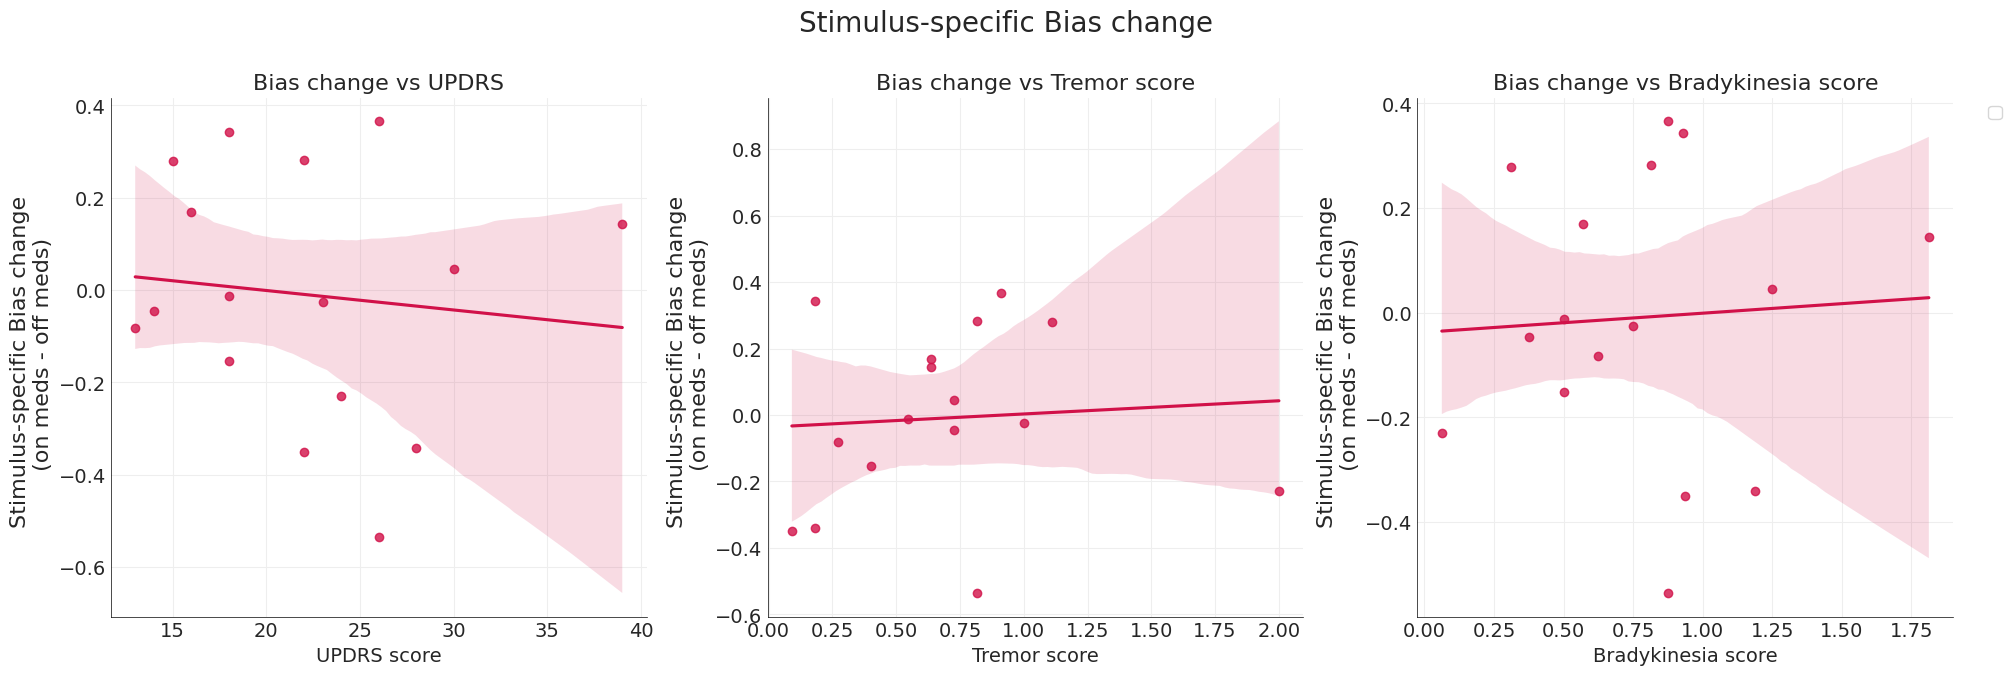

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.regplot(x='UPDRS', y='bias_separation_change', data=temp_metadata, ax=axs[0])
axs[0].set_title('Bias change vs UPDRS')
axs[0].set_xlabel('UPDRS score')

sns.regplot(x='tremor_score', y='bias_separation_change', data=temp_metadata, ax=axs[1])
axs[1].set_title('Bias change vs Tremor score')
axs[1].set_xlabel('Tremor score')

sns.regplot(x='bradykinesia_score', y='bias_separation_change', data=temp_metadata, ax=axs[2])
axs[2].set_title('Bias change vs Bradykinesia score')
axs[2].set_xlabel('Bradykinesia score')

for ax in axs:
    ax.set_ylabel('Stimulus-specific Bias change \n (on meds - off meds)', fontsize=16)
    # add bottom and left box line
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Stimulus-specific Bias change', fontsize=20, y=1.10)
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


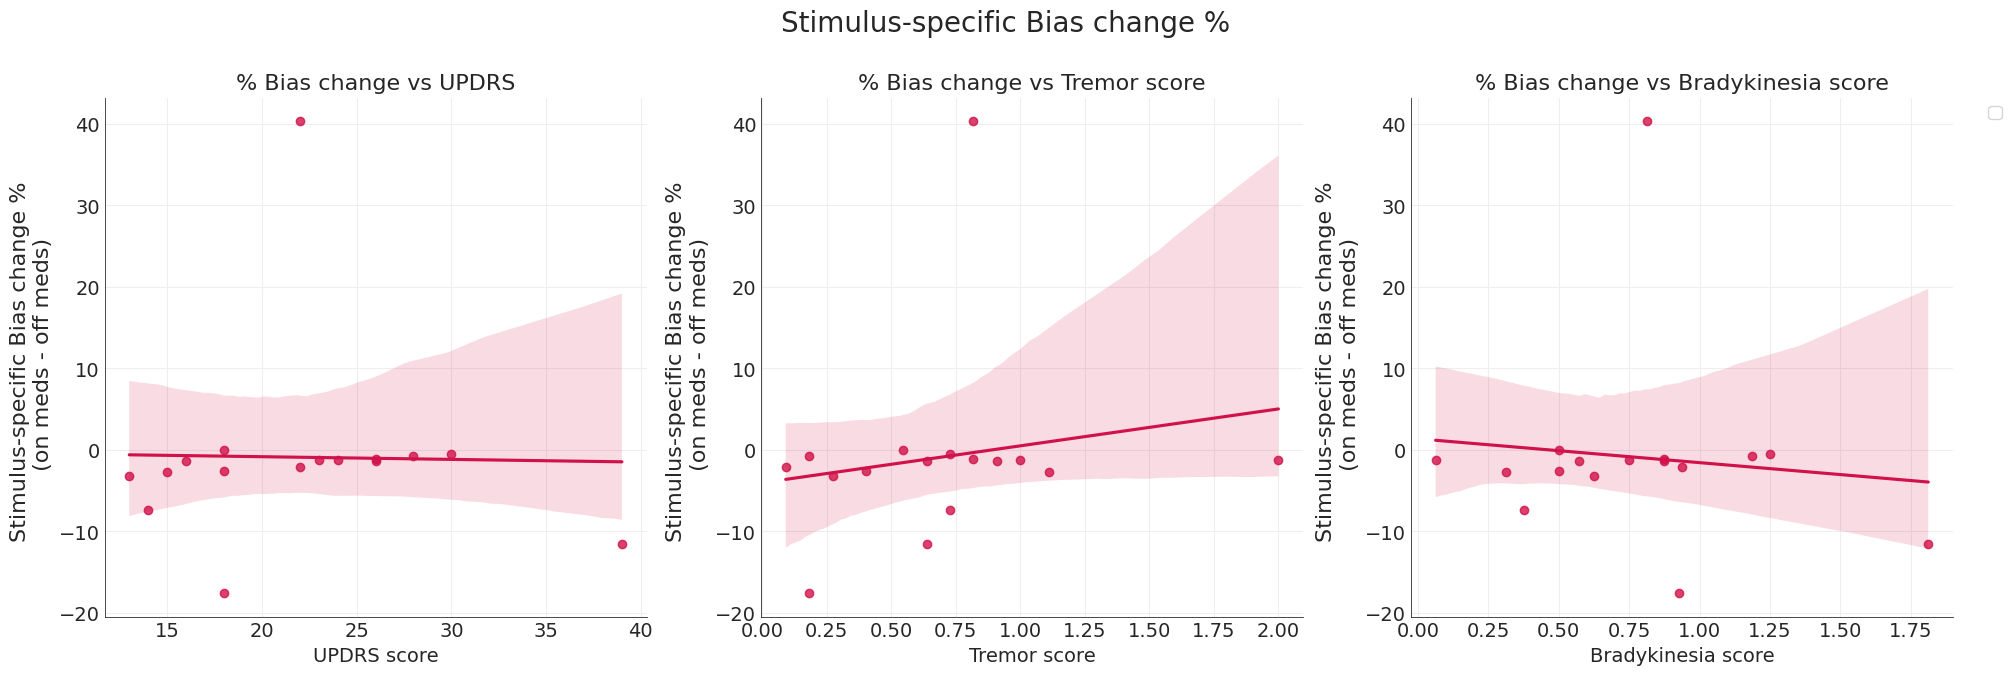

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.regplot(x='UPDRS', y='bias_separation_prct_change', data=temp_metadata, ax=axs[0])
axs[0].set_title('% Bias change vs UPDRS')
axs[0].set_xlabel('UPDRS score')

sns.regplot(x='tremor_score', y='bias_separation_prct_change', data=temp_metadata, ax=axs[1])
axs[1].set_title('% Bias change vs Tremor score')
axs[1].set_xlabel('Tremor score')

sns.regplot(x='bradykinesia_score', y='bias_separation_prct_change', data=temp_metadata, ax=axs[2])
axs[2].set_title('% Bias change vs Bradykinesia score')
axs[2].set_xlabel('Bradykinesia score')

for ax in axs:
    ax.set_ylabel('Stimulus-specific Bias change % \n (on meds - off meds)', fontsize=16)
    # add bottom and left box line
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Stimulus-specific Bias change %', fontsize=20, y=1.10)
plt.tight_layout()
plt.show()

### Correlational Analysis using statsmodel

In [ ]:
import statsmodels.api as sm

# Define independent (X) and dependent (y) variables
X = temp_metadata[['UPDRS', 'tremor_score', 'bradykinesia_score']]
# Add a constant to X (intercept term)
X = sm.add_constant(X)

individual prior correlations

In [ ]:
print("------------------------------------------------------")
print(f"Model for Positive Prior Bias Change ")
print("------------------------------------------------------")

y = temp_metadata['positive_bias_change']
# Fit the model
model = sm.OLS(y, X).fit()
# Print the summary
print(model.summary())

------------------------------------------------------
Model for Positive Prior Bias Change 
------------------------------------------------------
                             OLS Regression Results                             
Dep. Variable:     positive_bias_change   R-squared:                       0.405
Model:                              OLS   Adj. R-squared:                  0.256
Method:                   Least Squares   F-statistic:                     2.722
Date:                  Tue, 18 Feb 2025   Prob (F-statistic):             0.0909
Time:                          21:23:07   Log-Likelihood:                 5.9850
No. Observations:                    16   AIC:                            -3.970
Df Residuals:                        12   BIC:                           -0.8797
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                         coef    std err  

In [ ]:
print("------------------------------------------------------")
print(f"Model for Equal Prior Bias Change ")
print("------------------------------------------------------")

y = temp_metadata['equal_bias_change']
# Fit the model
model = sm.OLS(y, X).fit()
# Print the summary
print(model.summary())

------------------------------------------------------
Model for Equal Prior Bias Change 
------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:      equal_bias_change   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1.637
Date:                Tue, 18 Feb 2025   Prob (F-statistic):              0.233
Time:                        21:24:24   Log-Likelihood:                 9.3077
No. Observations:                  16   AIC:                            -10.62
Df Residuals:                      12   BIC:                            -7.525
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|   

In [ ]:
print("------------------------------------------------------")
print(f"Model for Positve Prior Bias Change % ")
print("------------------------------------------------------")

y = temp_metadata['positive_bias_prct_change']
# Fit the model
model = sm.OLS(y, X).fit()
# Print the summary
print(model.summary())

print("------------------------------------------------------")
print(f"Model for Equal Prior Bias Change % ")
print("------------------------------------------------------")

y = temp_metadata['equal_bias_prct_change']
# Fit the model
model = sm.OLS(y, X).fit()
# Print the summary
print(model.summary())

------------------------------------------------------
Model for Positve Prior Bias Change % 
------------------------------------------------------
                                OLS Regression Results                               
Dep. Variable:     positive_bias_prct_change   R-squared:                       0.348
Model:                                   OLS   Adj. R-squared:                  0.185
Method:                        Least Squares   F-statistic:                     2.135
Date:                       Tue, 18 Feb 2025   Prob (F-statistic):              0.149
Time:                               21:25:44   Log-Likelihood:                -4.4823
No. Observations:                         16   AIC:                             16.96
Df Residuals:                             12   BIC:                             20.05
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                 

Stimulus-specific correlations

In [ ]:
print("------------------------------------------------------")
print(f"Model for bias_separation_change")
print("------------------------------------------------------")

y = temp_metadata['bias_separation_change']
# Fit the model
model = sm.OLS(y, X).fit()
# Print the summary
print(model.summary())

------------------------------------------------------
Model for bias_separation_change
------------------------------------------------------
                              OLS Regression Results                              
Dep. Variable:     bias_separation_change   R-squared:                       0.444
Model:                                OLS   Adj. R-squared:                  0.305
Method:                     Least Squares   F-statistic:                     3.191
Date:                    Tue, 18 Feb 2025   Prob (F-statistic):             0.0627
Time:                            21:19:08   Log-Likelihood:                 3.6286
No. Observations:                      16   AIC:                            0.7427
Df Residuals:                          12   BIC:                             3.833
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                         co

In [ ]:

print("------------------------------------------------------")
print(f"Model for bias_separation_prct_change")
print("------------------------------------------------------")
y = temp_metadata['bias_separation_prct_change']
# Fit the model
model = sm.OLS(y, X).fit()
# Print the summary
print(model.summary())


------------------------------------------------------
Model for bias_separation_prct_change
------------------------------------------------------
                                 OLS Regression Results                                
Dep. Variable:     bias_separation_prct_change   R-squared:                       0.034
Model:                                     OLS   Adj. R-squared:                 -0.208
Method:                          Least Squares   F-statistic:                    0.1394
Date:                         Tue, 18 Feb 2025   Prob (F-statistic):              0.935
Time:                                 21:21:15   Log-Likelihood:                -61.619
No. Observations:                           16   AIC:                             131.2
Df Residuals:                               12   BIC:                             134.3
Df Model:                                    3                                         
Covariance Type:                     nonrobust              